In [5]:
# %%
from pyspark.sql import SparkSession
from pyspark.sql import functions as F



In [6]:
spark = (SparkSession.builder.appName("NBA_Shot_Analysis").getOrCreate())
# sc = spark.sparkContext

In [7]:
# import catboost_spark

## Read .csv files

In [8]:
# !pyspark --version

In [9]:
df = spark.read.csv("NBA shot log 16-17-regular season/Shot data/*.csv", header=True, inferSchema=True)
players_df = spark.read.csv("NBA shot log 16-17-regular season/Player Regular 16-17 Stats.csv", header=True,
                            inferSchema=True)

## Display schema of DataFrames.

In [10]:
# analyze data
df.printSchema()

root
 |-- self previous shot: string (nullable = true)
 |-- player position: string (nullable = true)
 |-- home game: string (nullable = true)
 |-- location x: integer (nullable = true)
 |-- opponent previous shot: string (nullable = true)
 |-- home team: string (nullable = true)
 |-- shot type: string (nullable = true)
 |-- points: integer (nullable = true)
 |-- away team: string (nullable = true)
 |-- location y: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- shoot player: string (nullable = true)
 |-- time from last shot: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- current shot outcome: string (nullable = true)


In [11]:
players_df.printSchema()

root
 |-- Date/Time of Update: 2017-05-09 4:34:01 PM: string (nullable = true)
 |-- Player ID: integer (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- Jersey Num: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- Height: string (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Birth Date: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Birth City: string (nullable = true)
 |-- Birth Country: string (nullable = true)
 |-- Rookie: string (nullable = true)
 |-- Team ID: integer (nullable = true)
 |-- Team Abbr: string (nullable = true)
 |-- Team City: string (nullable = true)
 |-- Team Name: string (nullable = true)
 |-- GamesPlayed: integer (nullable = true)
 |-- Fg2PtAtt: integer (nullable = true)
 |-- Fg2PtMade: integer (nullable = true)
 |-- Fg3PtAtt: integer (nullable = true)
 |-- Fg3PtMade: integer (nullable = true)
 |-- FtAtt: integer (nullable = true)
 |-- FtMade: integer (nu

In [12]:
df.show()

+------------------+---------------+---------+----------+----------------------+---------+--------------------+------+---------+----------+-------------------+----------+--------------------+-------------------+-------+--------------------+
|self previous shot|player position|home game|location x|opponent previous shot|home team|           shot type|points|away team|location y|               time|      date|        shoot player|time from last shot|quarter|current shot outcome|
+------------------+---------------+---------+----------+----------------------+---------+--------------------+------+---------+----------+-------------------+----------+--------------------+-------------------+-------+--------------------+
|              NULL|             SG|       No|       711|                  NULL|      TOR|           Jump Shot|     2|      DET|       267|2024-05-10 00:15:00|2016-10-26|Kentavious Caldwe...|               NULL|      1|              SCORED|
|            SCORED|             SF|

In [13]:
players_df.show()

+------------------------------------------+---------+-------------+---------+----------+--------+------+------+----------+---+-----------------+-------------+------+-------+---------+-------------+-------------+-----------+--------+---------+--------+---------+-----+------+
|Date/Time of Update: 2017-05-09 4:34:01 PM|Player ID|     LastName|FirstName|Jersey Num|Position|Height|Weight|Birth Date|Age|       Birth City|Birth Country|Rookie|Team ID|Team Abbr|    Team City|    Team Name|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|FtAtt|FtMade|
+------------------------------------------+---------+-------------+---------+----------+--------+------+------+----------+---+-----------------+-------------+------+-------+---------+-------------+-------------+-----------+--------+---------+--------+---------+-----+------+
|                                      NULL|    10138|      Abrines|     Alex|         8|       F| 6'6""|   190|  8/1/1993| 23|Palma de Mallorca|        Spain|     Y|     9

## Data Cleaning

In [14]:
players_df = players_df.withColumn("Name", F.concat_ws(" ", players_df.FirstName, players_df.LastName))

In [15]:
df = df.drop('date', 'home game', 'home team', 'away team', 'FtMade',
             'self previous shot', 'opponent previous shot')

In [16]:
players_df = players_df.drop("Date/Time of Update: 2017-05-09 4:34:01 PM", "Player ID",
                             "Jersey Num", "Birth Date", "Birth City", "Birth Country",
                             "Team ID", "Team Abbr", "Team City", "Team Name", "FirstName",
                             "LastName", "Position", "FtAtt", "FtMade")

players_df.show()

+------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
|Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|                Name|
+------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
| 6'6""|   190| 23|     Y|         73|      94|       40|     247|       94|        Alex Abrines|
| 6'7""|   240| 26|     N|         46|      80|       33|      90|       37|          Quincy Acy|
| 7'0""|   255| 23|     N|         81|     652|      374|       2|        0|        Steven Adams|
| 6'5""|   215| 31|     N|         71|     269|      123|     151|       62|       Arron Afflalo|
| 7'2""|   248| 29|     N|         55|     174|       89|       4|        0|       Alexis Ajinca|
|6'11""|   245| 28|     N|         72|      86|       45|       0|        0|        Cole Aldrich|
|6'11""|   240| 31|     N|         81|     993|      477|      56|       23|   LaMarcus Aldridge|
| 6'8""|   245| 21| 

In [17]:
df.describe().show()

+-------+---------------+------------------+--------------------+------------------+------------------+-------------+-------------------+------------------+--------------------+
|summary|player position|        location x|           shot type|            points|        location y| shoot player|time from last shot|           quarter|current shot outcome|
+-------+---------------+------------------+--------------------+------------------+------------------+-------------+-------------------+------------------+--------------------+
|  count|         210072|            209675|              210072|            210072|            209675|       210072|             200072|            210072|              210072|
|   mean|           NULL| 468.5245069750805|                NULL| 2.316129707909669|249.44723023727198|         NULL| 33.279489383821826|2.4803829163334474|                NULL|
| stddev|           NULL|345.06365363364534|                NULL|0.4649653157204641|111.02319967898578|       

### Handling Missing Values

In [18]:
df.select([F.sum(F.when(df[col].isNull(), 1).otherwise(0)).alias(col) for col in df.columns]).show()

+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+
|player position|location x|shot type|points|location y|time|shoot player|time from last shot|quarter|current shot outcome|
+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+
|              0|       397|        0|     0|       397|   0|           0|              10000|      0|                   0|
+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+


In [19]:
# knn impuation for time from last shot
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["time from last shot"], outputCols=["time from last shot"])
df = imputer.fit(df).transform(df)

In [20]:
df = df.dropna(subset=['location x', 'location y'])

In [21]:
players_df.describe().show()

+-------+------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+-------------+
|summary|Height|            Weight|               Age|Rookie|       GamesPlayed|          Fg2PtAtt|         Fg2PtMade|          Fg3PtAtt|        Fg3PtMade|         Name|
+-------+------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+-------------+
|  count|   510|               510|               508|   517|               517|               517|               517|               517|              517|          517|
|   mean|  NULL|219.36274509803923|26.828740157480315|  NULL| 56.41586073500967|277.87620889748547|139.86847195357834|128.45261121856868|45.93617021276596|         NULL|
| stddev|  NULL|27.184080779978242|4.4014746483738465|  NULL|26.839228128882763| 276.3181519194374|142.57880356135038|146.35076591552158|55.5304388492

In [22]:
players_df = players_df.filter("Fg2PtAtt != 0 and Fg3PtAtt != 0")

In [23]:
players_df.select(
    [F.sum(F.when(players_df[col].isNull(), 1).otherwise(0)).alias(col) for col in players_df.columns]).show()

+------+------+---+------+-----------+--------+---------+--------+---------+----+
|Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|Name|
+------+------+---+------+-----------+--------+---------+--------+---------+----+
|     3|     3|  5|     0|          0|       0|        0|       0|        0|   0|
+------+------+---+------+-----------+--------+---------+--------+---------+----+


In [24]:
split_col = F.split(players_df['Height'], "'")
split_col2 = F.split(split_col[1], '"')
# print the split colum
players_df = players_df.withColumn('Height', split_col[0].cast("int") * 30.48 + split_col2[0].cast("int") * 2.54)

In [25]:
age_mean = players_df.select(F.mean(players_df['Age'])).collect()[0][0]
height_mean = players_df.select(F.mean(players_df['Height'])).collect()[0][0]
weight_mean = players_df.select(F.mean(players_df['Weight'])).collect()[0][0]

players_df = players_df.fillna(age_mean, subset=['Age'])
players_df = players_df.fillna(height_mean, subset=['Height'])
players_df = players_df.fillna(weight_mean, subset=['Weight'])

## Joining DataFrames

In [26]:
df = df.join(players_df, df["shoot player"] == players_df["Name"])

In [27]:
df.show()

+---------------+----------+--------------------+------+----------+-------------------+--------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
|player position|location x|           shot type|points|location y|               time|        shoot player|time from last shot|quarter|current shot outcome|            Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|                Name|
+---------------+----------+--------------------+------+----------+-------------------+--------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
|             SG|       711|           Jump Shot|     2|       267|2024-05-10 00:15:00|Kentavious Caldwe...|                 33|      1|              SCORED|195.57999999999998|   205| 24|     N|        

In [28]:
df = df.withColumn("2PTsAccuracy", df.Fg2PtMade / df.Fg2PtAtt)
df = df.withColumn("3PTsAccuracy", df.Fg3PtMade / df.Fg3PtAtt)
df = df.drop("Fg2PtMade", "Fg2PtAtt", "Fg3PtMade", "Fg3PtAtt")

In [29]:
df = df.drop("shoot player", "Name")
df.show()

+---------------+----------+--------------------+------+----------+-------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+-------------------+-------------------+
|player position|location x|           shot type|points|location y|               time|time from last shot|quarter|current shot outcome|            Height|Weight|Age|Rookie|GamesPlayed|       2PTsAccuracy|       3PTsAccuracy|
+---------------+----------+--------------------+------+----------+-------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+-------------------+-------------------+
|             SG|       711|           Jump Shot|     2|       267|2024-05-10 00:15:00|                 33|      1|              SCORED|195.57999999999998|   205| 24|     N|         79| 0.4419551934826884| 0.3501144164759725|
|             SF|       637|ris 25' 3PT Pullu...|     3|       275|2024-05-10 00:48:00|         

In [30]:
# check for duplicate rows
print(df.count())
print(df.distinct().count())

df = df.dropDuplicates()

204762
204761


In [31]:
# check for unique values for all columns
for col in df.columns:
    print(col, df.select(col).distinct().count())
    

player position 7
location x 717
shot type 834
points 2
location y 489
time 719
time from last shot 200
quarter 8
current shot outcome 3
Height 21
Weight 86
Age 22
Rookie 2
GamesPlayed 78
2PTsAccuracy 393
3PTsAccuracy 317


In [32]:
#print unique values in quarter
df.select("quarter").distinct().show()

+-------+
|quarter|
+-------+
|      1|
|      6|
|      3|
|      5|
|      4|
|      8|
|      7|
|      2|
+-------+


## Exploratory Data Analysis

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


<Axes: xlabel='current shot outcome', ylabel='count'>

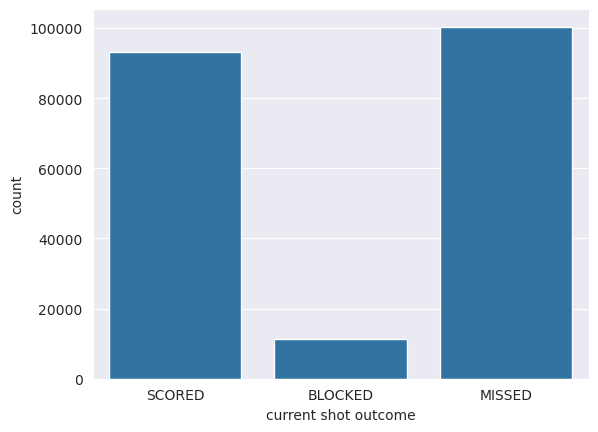

In [34]:
current_shot_outcome = df.groupBy("current shot outcome").count().toPandas()
sns.barplot(x="current shot outcome", y="count", data=current_shot_outcome)

In [35]:
# drop blocked shots
df = df.filter(df["current shot outcome"] != "BLOCKED")

<Axes: xlabel='location x', ylabel='Scored'>

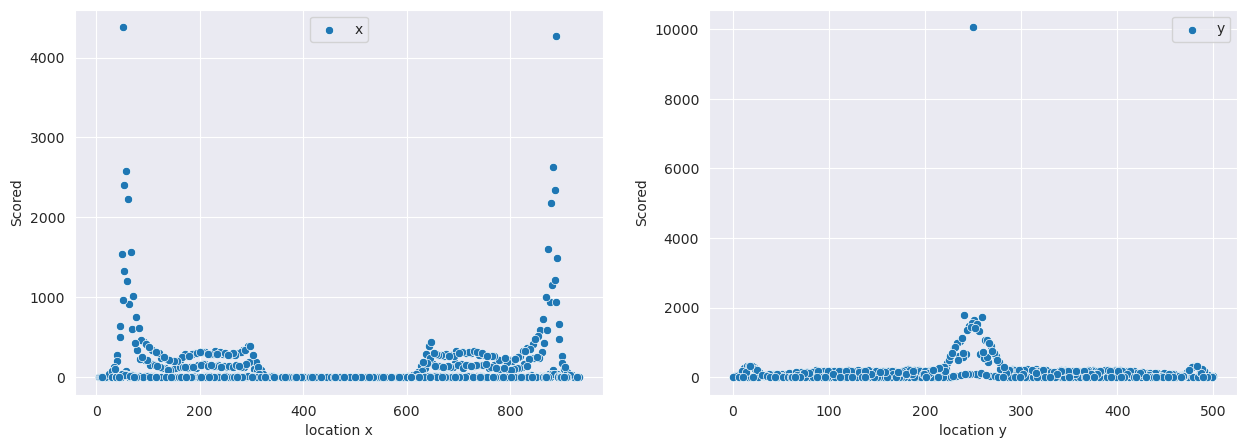

In [36]:
## plot height vs current shot outcome
shotcount_locationx = df.groupBy("location x").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

shotcount_locationy = df.groupBy("location y").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

# plot location x and y vs current shot outcome on same plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="location y", y="Scored", data=shotcount_locationy, label="y", ax=axs[1])
sns.scatterplot(x="location x", y="Scored", data=shotcount_locationx, label="x", ax=axs[0])

<Axes: xlabel='location x', ylabel='Missed'>

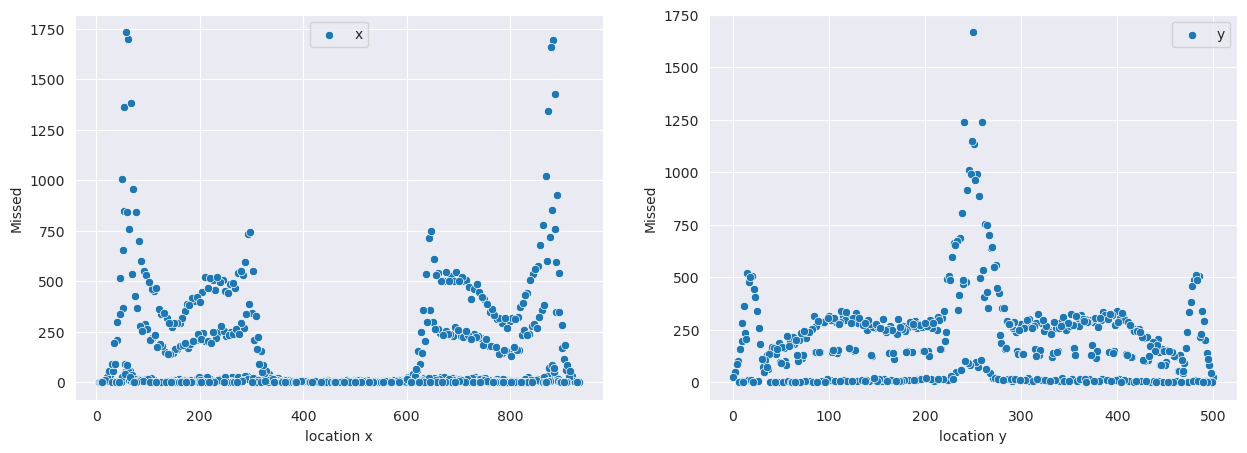

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="location y", y="Missed", data=shotcount_locationy, label="y", ax=axs[1])
sns.scatterplot(x="location x", y="Missed", data=shotcount_locationx, label="x", ax=axs[0])

In [38]:
# get x to the nearest basket
max_x = df.agg(F.max(df["location x"])).collect()[0][0]
df = df.withColumn("location x",
                   F.when(df["location x"] > max_x / 2, max_x - df["location x"]).otherwise(df["location x"]))

<Axes: xlabel='player position', ylabel='Count'>

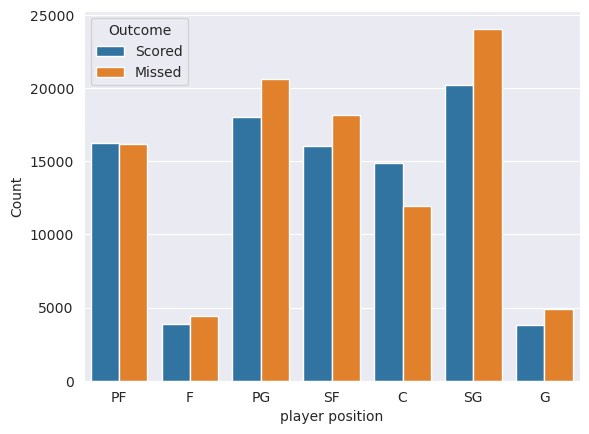

In [39]:
playerposition = df.groupBy("player position").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

playerposition_melted = playerposition.melt(id_vars=["player position"], value_vars=["Scored", "Missed"],
                                            var_name="Outcome", value_name="Count")

sns.barplot(x="player position", y="Count", hue="Outcome", data=playerposition_melted)


<Axes: xlabel='player position', ylabel='2PTsAccuracy'>

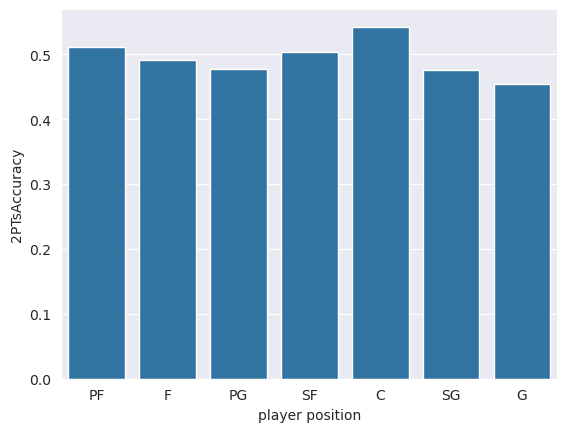

In [40]:
position = df.groupBy("player position").agg(F.mean("2PTsAccuracy").alias("2PTsAccuracy")).toPandas()

sns.barplot(x="player position", y="2PTsAccuracy", data=position)

<Axes: xlabel='player position', ylabel='3PTsAccuracy'>

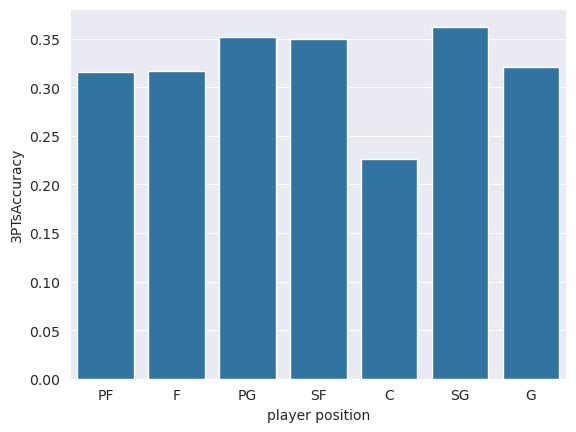

In [41]:
position = df.groupBy("player position").agg(F.mean("3PTsAccuracy").alias("3PTsAccuracy")).toPandas()

sns.barplot(x="player position", y="3PTsAccuracy", data=position)

<Axes: xlabel='points', ylabel='Count'>

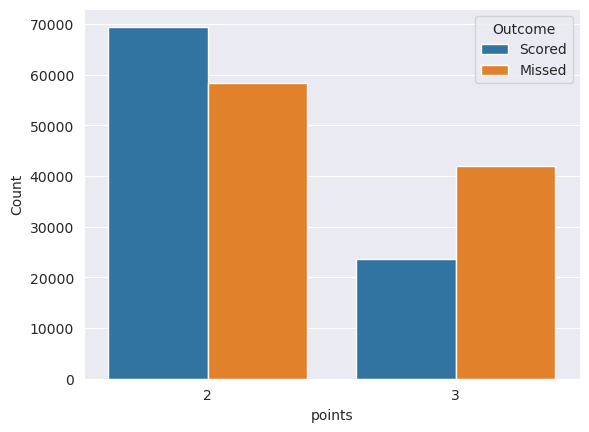

In [42]:
points = df.groupBy("points").agg(F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
                                  F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

points_melted = points.melt(id_vars=["points"], value_vars=["Scored", "Missed"], var_name="Outcome", value_name="Count")

sns.barplot(x="points", y="Count", hue="Outcome", data=points_melted)

<Axes: xlabel='Rookie', ylabel='Count'>

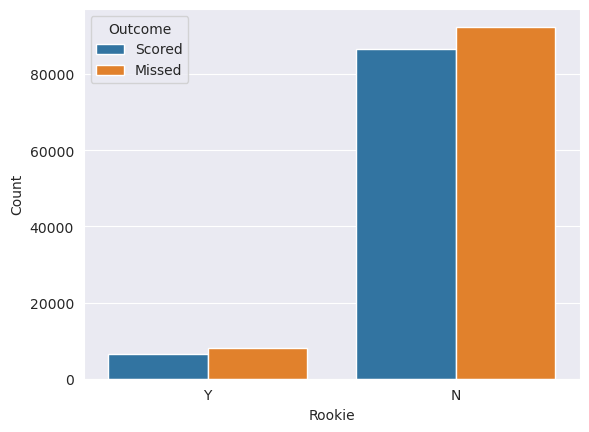

In [43]:
# Rookie = Y and Veteran = N
rookie = df.groupBy("Rookie").agg(F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
                                  F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

rookie_melted = rookie.melt(id_vars=["Rookie"], value_vars=["Scored", "Missed"], var_name="Outcome", value_name="Count")

sns.barplot(x="Rookie", y="Count", hue="Outcome", data=rookie_melted)


In [44]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

numerical_columns = ['time']
category_columns = ["player position", "Rookie", 'quarter', 'shot type']
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in category_columns]

for indexer in indexers:
    df = indexer.fit(df).transform(df)

encoders = OneHotEncoder(inputCol="player position_index", outputCol="player position_encoded")

df = encoders.fit(df).transform(df).drop("player position", "Rookie", "player position_index", 'quarter', 'shot type')

# df.show()

In [45]:
from pyspark.sql.functions import unix_timestamp

# Assuming df is your DataFrame and "timestamp_column" is the column with the timestamp
df = df.withColumn("time", unix_timestamp("time"))

<Axes: >

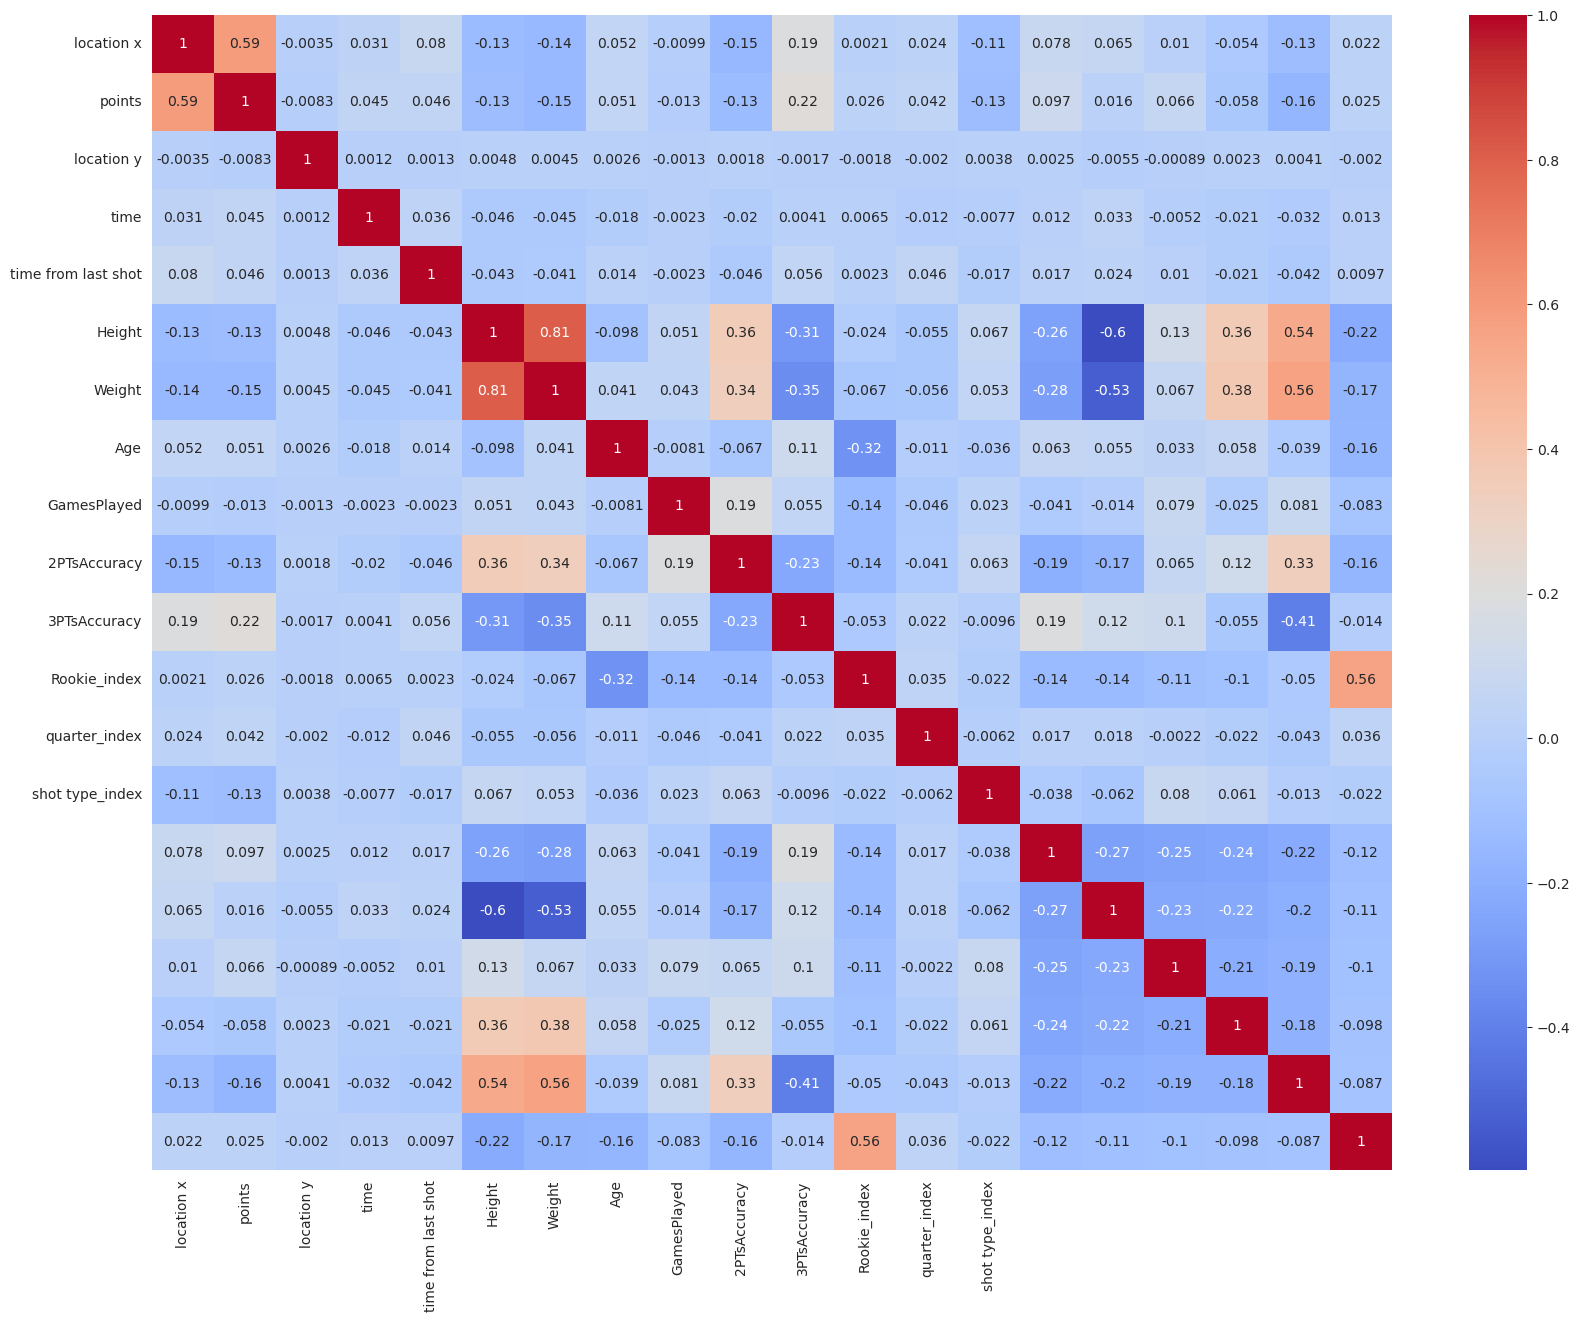

In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

column_names = df.columns
column_names.remove("current shot outcome")

assembler = VectorAssembler(inputCols=column_names, outputCol="features")
matrix = Correlation.corr(assembler.transform(df), "features").head()[0].toArray()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(matrix, annot=True, xticklabels=column_names[:-1], yticklabels=column_names[:-1], ax=ax, cmap="coolwarm")

In [47]:
df.show()

+----------+------+----------+----------+-------------------+--------------------+------------------+------+---+-----------+-------------------+-------------------+------------+-------------+---------------+-----------------------+
|location x|points|location y|      time|time from last shot|current shot outcome|            Height|Weight|Age|GamesPlayed|       2PTsAccuracy|       3PTsAccuracy|Rookie_index|quarter_index|shot type_index|player position_encoded|
+----------+------+----------+----------+-------------------+--------------------+------------------+------+---+-----------+-------------------+-------------------+------------+-------------+---------------+-----------------------+
|        51|     2|       254|1715302440|                 26|              SCORED|            210.82|   279| 23|         82|  0.532150776053215| 0.2857142857142857|         0.0|          2.0|            3.0|          (6,[4],[1.0])|
|        91|     2|       387|1715305140|                 33|           

# split data into training and testing

In [48]:
df = df.drop("feature_noScaling")

In [49]:
column_names = [col for col in column_names if
                col not in ["player position_encoded", "Rookie_index", "2PTsAccuracy","3PTsAccuracy", "points"]]
assembler = VectorAssembler(inputCols=column_names, outputCol="feature_noScaling")
df = assembler.transform(df)

train, test = df.randomSplit([0.8, 0.2])

In [50]:
train.show()

+----------+------+----------+----------+-------------------+--------------------+------------------+------+---+-----------+-------------------+-------------------+------------+-------------+---------------+-----------------------+--------------------+
|location x|points|location y|      time|time from last shot|current shot outcome|            Height|Weight|Age|GamesPlayed|       2PTsAccuracy|       3PTsAccuracy|Rookie_index|quarter_index|shot type_index|player position_encoded|   feature_noScaling|
+----------+------+----------+----------+-------------------+--------------------+------------------+------+---+-----------+-------------------+-------------------+------------+-------------+---------------+-----------------------+--------------------+
|         3|     3|       480|1715317560|                 20|              MISSED|            205.74|   227| 26|         80|  0.547752808988764|0.38461538461538464|         0.0|          0.0|            0.0|          (6,[3],[1.0])|[3.0,480.0

# normalize data

In [51]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="feature_noScaling", outputCol="scaled_features")
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [52]:
assembler = VectorAssembler(
    inputCols=["scaled_features", "player position_encoded", "Rookie_index", "2PTsAccuracy","3PTsAccuracy", "points"],
    outputCol="features")
train = assembler.transform(train).select("features", "current shot outcome")
test = assembler.transform(test).select("features", "current shot outcome")

## Model Building

In [53]:
train = train.withColumn("current shot outcome", F.when(df["current shot outcome"] == "SCORED", 1).otherwise(0))
test = test.withColumn("current shot outcome", F.when(df["current shot outcome"] == "SCORED", 1).otherwise(0))

In [54]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="current shot outcome")
lr_model = lr.fit(train)

train_predictions = lr_model.transform(train)
test_predictions = lr_model.transform(test)

train_predictions.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|            features|current shot outcome|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|(20,[0,1,2,3,4,5,...|                   0|[-0.3176911609052...|[0.42123853245358...|       1.0|
|[0.05507305919197...|                   1|[-0.3270567135755...|[0.41895694194323...|       1.0|
|[0.05507305919197...|                   1|[-0.5572449827327...|[0.36418515687952...|       1.0|
|[0.07710228286876...|                   0|[-0.5150570945575...|[0.37400877480481...|       1.0|
|(20,[0,1,2,3,4,5,...|                   0|[-0.0827443151306...|[0.47932571562185...|       1.0|
|[0.11014611838394...|                   1|[-0.1128067652348...|[0.47182817708754...|       1.0|
|[0.14318995389912...|                   1|[-0.3907506114846...|[0.40353661933584...|       1.0|
|[0.14318995389912...|        

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="current shot outcome")
train_auc = evaluator.evaluate(train_predictions)

print("Train AUC: ", train_auc)

test_auc = evaluator.evaluate(test_predictions)
print("Test AUC: ", test_auc)

Train AUC:  0.6418083449401898
Test AUC:  0.6375044540915923


In [56]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="current shot outcome")
rf_model = rf.fit(train)

train_predictions = rf_model.transform(train)
test_predictions = rf_model.transform(test)

train_predictions.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|            features|current shot outcome|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|(20,[0,1,2,3,4,5,...|                   0|[12.1141861156847...|[0.60570930578423...|       0.0|
|[0.05507305919197...|                   1|[12.0606483951441...|[0.60303241975720...|       0.0|
|[0.05507305919197...|                   1|[11.1730275142496...|[0.55865137571248...|       0.0|
|[0.07710228286876...|                   0|[9.24581879218765...|[0.46229093960938...|       1.0|
|(20,[0,1,2,3,4,5,...|                   0|[12.6032332651285...|[0.63016166325642...|       0.0|
|[0.11014611838394...|                   1|[12.6390691059489...|[0.63195345529744...|       0.0|
|[0.14318995389912...|                   1|[9.50756847040944...|[0.47537842352047...|       1.0|
|[0.14318995389912...|        

In [57]:
train_auc = evaluator.evaluate(train_predictions)

print("Train AUC: ", train_auc)

test_auc = evaluator.evaluate(test_predictions)
print("Test AUC: ", test_auc)

Train AUC:  0.6837977205423413
Test AUC:  0.6782276951416301
